In [6]:
%matplotlib inline
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from numpy import concatenate
from keras.utils import to_categorical
from math import sqrt

In [7]:
df = pd.read_csv('/Users/renaudleurquin/Documents/TSP/2A/Cassiopé/BDD/FDAX_indicateurs.txt', sep='\t', skipinitialspace=True)
#skipinitialspace permet de retirer les espaces génants sur les colonnes et sur les données

#suppression des colonnes non utiles à la prédiction
colonnes = ['# of Trades','OHLC Avg', 'HLC Avg', 'Volume', 'HL Avg', 'Bid Volume', 'Ask Volume', 'Open.1','High.1', 'Low.1', "etat variable 'Volume'","etat variable 'DeltaSpread'", "etat variable 'PriceChange'","etat variable 'Delta'", 'volume', 'priceChange', "etat variable 'spread'", "etat variable 'open'","etat variable 'close'", "etat variable 'deltaOpen'","etat variable 'deltaClose'", 'weak', 'strong', 'Strong Triangle','weak Triangle', 'delta_sos', 'delta_sow', "Signal d'achat",'Signal de vente', 'trendFilter']
df.drop(colonnes, axis = 1, inplace = True)

df['Date&Time'] = df['Date'] +' '+ df['Time']
df['date_time'] = pd.to_datetime(df['Date&Time'], format='%d/%m/%Y %H:%M:%S.%f')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')
df.drop(['Date', 'Date&Time'], axis=1, inplace=True)
df = df[['date_time', 'Time', 'Open', 'High', 'Low', 'Last','Close']]
df

,date_time,Time,Open,High,Low,Last,Close
0,2013-01-04 08:00:00,1900-01-01 08:00:00,7842.0,7844.5,7839.5,7840.5,-10
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,7838.0,-145
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,-262
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,-219
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,-274
...,...,...,...,...,...,...,...
296602,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,13149.5,-146385
296603,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,13144.5,-146344
296604,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,13154.5,-146270
296605,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,13151.0,-146290


In [8]:
df['close_moy_mobile'] = df['Close'].rolling(23).mean()
df['close_std_mobile'] = df['Close'].rolling(23).std(ddof=0)
df['close_zscore'] = (df['Close']-df['close_moy_mobile'])/(df['close_std_mobile'])
df.drop(['close_moy_mobile', 'close_std_mobile'], axis=1, inplace=True)
df = df.iloc[22:,:]

In [9]:
df.head(30)

,date_time,Time,Open,High,Low,Last,Close,close_zscore
22,2013-01-04 09:50:00,1900-01-01 09:50:00,7844.5,7849.5,7844.0,7848.5,-129,1.409756
23,2013-01-04 09:55:00,1900-01-01 09:55:00,7849.0,7850.5,7846.0,7847.5,-178,1.164464
24,2013-01-04 10:00:00,1900-01-01 10:00:00,7847.5,7847.5,7844.0,7846.0,-242,0.524059
25,2013-01-04 10:05:00,1900-01-01 10:05:00,7845.5,7848.0,7845.0,7848.0,-99,1.931948
26,2013-01-04 10:10:00,1900-01-01 10:10:00,7847.5,7848.5,7842.5,7847.5,-146,1.349350
27,2013-01-04 10:15:00,1900-01-01 10:15:00,7847.0,7847.5,7845.0,7846.5,-151,1.200943
28,2013-01-04 10:20:00,1900-01-01 10:20:00,7846.0,7846.5,7842.5,7844.5,-172,0.953024
29,2013-01-04 10:25:00,1900-01-01 10:25:00,7844.5,7846.5,7844.0,7844.0,-185,0.787601
30,2013-01-04 10:30:00,1900-01-01 10:30:00,7844.0,7846.0,7843.5,7844.0,-247,0.187469
31,2013-01-04 10:35:00,1900-01-01 10:35:00,7844.5,7844.5,7839.5,7840.0,-299,-0.303788


In [10]:
df.index = df.index - 22
df

,date_time,Time,Open,High,Low,Last,Close,close_zscore
0,2013-01-04 09:50:00,1900-01-01 09:50:00,7844.5,7849.5,7844.0,7848.5,-129,1.409756
1,2013-01-04 09:55:00,1900-01-01 09:55:00,7849.0,7850.5,7846.0,7847.5,-178,1.164464
2,2013-01-04 10:00:00,1900-01-01 10:00:00,7847.5,7847.5,7844.0,7846.0,-242,0.524059
3,2013-01-04 10:05:00,1900-01-01 10:05:00,7845.5,7848.0,7845.0,7848.0,-99,1.931948
4,2013-01-04 10:10:00,1900-01-01 10:10:00,7847.5,7848.5,7842.5,7847.5,-146,1.349350
...,...,...,...,...,...,...,...,...
296580,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,13149.5,-146385,1.806250
296581,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,13144.5,-146344,2.570412
296582,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,13154.5,-146270,3.253454
296583,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,13151.0,-146290,2.348853


In [11]:
Y=[]
n = df.shape[0]
for i in range (1,n) : 
    if df.iloc[i,5]<df.iloc[i-1,5]:
        Y.append(-1)
    if df.iloc[i,5]==df.iloc[i-1,5]:
        Y.append(0)
    if df.iloc[i,5]>df.iloc[i-1,5]:
        Y.append(1) 

In [12]:
df = df.iloc[1:,:]
df.insert(8,'Y',Y)

date_limite = dt.datetime.strptime('2014-01-01 08:00:00.0', '%Y-%m-%d %H:%M:%S.%f')
dix_huit = dt.datetime.strptime('18:05:00.0', '%H:%M:%S.%f')

df_2013 = df.loc[(df["date_time"]<date_limite) & (df["Time"]<dix_huit)]

df_2013

,date_time,Time,Open,High,Low,Last,Close,close_zscore,Y
1,2013-01-04 09:55:00,1900-01-01 09:55:00,7849.0,7850.5,7846.0,7847.5,-178,1.164464,-1
2,2013-01-04 10:00:00,1900-01-01 10:00:00,7847.5,7847.5,7844.0,7846.0,-242,0.524059,-1
3,2013-01-04 10:05:00,1900-01-01 10:05:00,7845.5,7848.0,7845.0,7848.0,-99,1.931948,1
4,2013-01-04 10:10:00,1900-01-01 10:10:00,7847.5,7848.5,7842.5,7847.5,-146,1.349350,-1
5,2013-01-04 10:15:00,1900-01-01 10:15:00,7847.0,7847.5,7845.0,7846.5,-151,1.200943,-1
...,...,...,...,...,...,...,...,...,...
42226,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,9652.5,-39561,1.760153,1
42227,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,9655.5,-39531,1.858150,1
42228,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,9658.0,-39538,1.592525,1
42229,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,9658.0,-39519,1.600485,0


In [13]:
#Il est nécessaire de changer l'index du dataframe pour le pre-processing des données
index = np.linspace(1,30242, num=30242, dtype='int64')
df_2013.index = index
df_2013.head(10)

,date_time,Time,Open,High,Low,Last,Close,close_zscore,Y
1,2013-01-04 09:55:00,1900-01-01 09:55:00,7849.0,7850.5,7846.0,7847.5,-178,1.164464,-1
2,2013-01-04 10:00:00,1900-01-01 10:00:00,7847.5,7847.5,7844.0,7846.0,-242,0.524059,-1
3,2013-01-04 10:05:00,1900-01-01 10:05:00,7845.5,7848.0,7845.0,7848.0,-99,1.931948,1
4,2013-01-04 10:10:00,1900-01-01 10:10:00,7847.5,7848.5,7842.5,7847.5,-146,1.349350,-1
5,2013-01-04 10:15:00,1900-01-01 10:15:00,7847.0,7847.5,7845.0,7846.5,-151,1.200943,-1
6,2013-01-04 10:20:00,1900-01-01 10:20:00,7846.0,7846.5,7842.5,7844.5,-172,0.953024,-1
7,2013-01-04 10:25:00,1900-01-01 10:25:00,7844.5,7846.5,7844.0,7844.0,-185,0.787601,-1
8,2013-01-04 10:30:00,1900-01-01 10:30:00,7844.0,7846.0,7843.5,7844.0,-247,0.187469,0
9,2013-01-04 10:35:00,1900-01-01 10:35:00,7844.5,7844.5,7839.5,7840.0,-299,-0.303788,-1
10,2013-01-04 10:40:00,1900-01-01 10:40:00,7840.5,7842.0,7837.0,7837.5,-382,-1.019202,-1


In [14]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [15]:
#On exclut la date et l'heure qui ne sont pas des données d'apprentissage et les labels
n = df_2013.shape[0]
limit = int(4*n/5)
values_app = df_2013.iloc[:limit,2:6].values

#Processus de normalisation à partir des données d'apprentissage
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values_app)

#Normalisation de l'ensemble des données à partir du modèle de normalisation construit sur les données d'apprentissage
values = df_2013.iloc[:,2:6]
normalized = scaler.transform(values)
processed_data = pd.DataFrame(normalized)
colonnes = ['Open', 'High', 'Low', 'Last']
processed_data.columns = colonnes

#J'ai mis tellement de temps à comprendre ce souci 
processed_data.index = processed_data.index+1 #car pour ajouter la colonne Y dans ce nouveau df, il faut que les indices correspondent
processed_data["close_zscore"] = df_2013["close_zscore"]
processed_data['Y'] = df_2013['Y']
processed_data = processed_data.reindex(columns=['Open', 'High', 'Low', 'close_zscore', 'Last', 'Y'])
values_processed = processed_data.values #numpy representation des données
processed_data

,Open,High,Low,close_zscore,Last,Y
1,0.236870,0.235461,0.243894,1.164464,0.236071,-1
2,0.235798,0.233333,0.242478,0.524059,0.235000,-1
3,0.234369,0.233688,0.243186,1.931948,0.236429,1
4,0.235798,0.234043,0.241416,1.349350,0.236071,-1
5,0.235441,0.233333,0.243186,1.200943,0.235357,-1
...,...,...,...,...,...,...
30238,1.524830,1.514539,1.521416,1.760153,1.525357,1
30239,1.525188,1.518085,1.522478,1.858150,1.527500,1
30240,1.527688,1.517730,1.524248,1.592525,1.529286,1
30241,1.529475,1.517730,1.524602,1.600485,1.529286,0


In [16]:
#Données d'apprentissage
X_train = values_processed[:limit,:4]
Y_train = values_processed[:limit,4]

#Données de test
X_test = values_processed[limit:,:4]
Y_test = values_processed[limit:,4]

print("Minimum value is %s" %(normalized.min()) )
print("Maximum value is %s" %(normalized.max()) )
print("======================================")
print()
print(X_train.shape[0], ' : number of train samples')
print(X_test.shape[0], ' : number of test samples')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Minimum value is 0.0
Maximum value is 1.531618435155413

24193  : number of train samples
6049  : number of test samples
X_train shape:  (24193, 4)
Y_train shape:  (24193,)
X_test shape:  (6049, 4)
Y_test shape:  (6049,)


In [17]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import activations
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [18]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
var_close = processed_data.iloc[:,3].values
var_close = var_close.reshape(-1,1)
print(normalized.shape[1])

4


In [20]:
scaled = np.concatenate((var_close, normalized), axis=1)
time_lag = 2
data_set_lstm = build_dataset(scaled, time_lag)
data_set_lstm.head(10)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2,1.164464,0.236870,0.235461,0.243894,0.236071,0.524059,0.235798,0.233333,0.242478,0.235000,1.931948,0.234369,0.233688,0.243186,0.236429
3,0.524059,0.235798,0.233333,0.242478,0.235000,1.931948,0.234369,0.233688,0.243186,0.236429,1.349350,0.235798,0.234043,0.241416,0.236071
4,1.931948,0.234369,0.233688,0.243186,0.236429,1.349350,0.235798,0.234043,0.241416,0.236071,1.200943,0.235441,0.233333,0.243186,0.235357
5,1.349350,0.235798,0.234043,0.241416,0.236071,1.200943,0.235441,0.233333,0.243186,0.235357,0.953024,0.234727,0.232624,0.241416,0.233929
6,1.200943,0.235441,0.233333,0.243186,0.235357,0.953024,0.234727,0.232624,0.241416,0.233929,0.787601,0.233655,0.232624,0.242478,0.233571
7,0.953024,0.234727,0.232624,0.241416,0.233929,0.787601,0.233655,0.232624,0.242478,0.233571,0.187469,0.233298,0.232270,0.242124,0.233571
8,0.787601,0.233655,0.232624,0.242478,0.233571,0.187469,0.233298,0.232270,0.242124,0.233571,-0.303788,0.233655,0.231206,0.239292,0.230714
9,0.187469,0.233298,0.232270,0.242124,0.233571,-0.303788,0.233655,0.231206,0.239292,0.230714,-1.019202,0.230797,0.229433,0.237522,0.228929
10,-0.303788,0.233655,0.231206,0.239292,0.230714,-1.019202,0.230797,0.229433,0.237522,0.228929,-1.575179,0.228653,0.227305,0.236106,0.227500
11,-1.019202,0.230797,0.229433,0.237522,0.228929,-1.575179,0.228653,0.227305,0.236106,0.227500,-2.935461,0.227581,0.225177,0.228673,0.222500


In [21]:
def data_new (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    ndrop=time_lag*5
    scaled = np.concatenate((var_close, normalized), axis=1)
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    processed_data_lstm.drop(columns = processed_data_lstm.columns[[ndrop, ndrop+1, ndrop+2, ndrop+3]], inplace=True)
    
    # split into train and test sets
    values = processed_data_lstm.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    train = values[:limit, :]
    test = values[limit:, :]
    
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)  

In [22]:
def optimal_model_2_layers():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mse', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)

In [23]:
train_X, train_y, test_X, test_y = data_new(2)
model_lstm = optimal_model_2_layers()
model_lstm.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=0)

In [24]:
def prediction (train_X, train_y, test_X, test_y, model):
    # faire la prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # inverser le scaling pour les données prédites
    inv_yhat = concatenate((yhat, test_X[:,:3]), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,0]

    # inverser le scaling pour les vraies valeurs 
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,:3]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    #liste des valeurs du Low
    val_low_test = df_2013.iloc[limit+2:,4].values

    #liste des valeurs du High
    val_high_test = df_2013.iloc[limit+2:,3].values
    
    return(inv_yhat, inv_y, val_low_test, val_high_test)

def tracer_prediction_no_date(nb_points, inv_yhat, inv_y, val_low_test, val_high_test):  #nb_points est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    x=np.linspace(1,nb_points,nb_points)
    plt.plot(x, inv_yhat[:nb_points], 'r', lw=1.5, label='Prediction')
    plt.plot(x, inv_y[:nb_points], 'b', lw=1.5, label='Valeur réelle')
    plt.plot(x, val_low_test[:nb_points], 'k--', lw=1, label='Low')
    plt.plot(x, val_high_test[:nb_points], 'k--', lw=1, label='High')
    plt.fill_between(x, val_low_test[:nb_points], val_high_test[:nb_points], color='0.7')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du Last', fontsize=14)
    plt.tight_layout()

In [25]:
prediction, reel, low, high = prediction(train_X, train_y, test_X, test_y, model_lstm)

In [26]:
print(df_2013.iloc[limit+2:,:].shape[0])
print(len(reel))
print(len(prediction))

6047
6047
6047


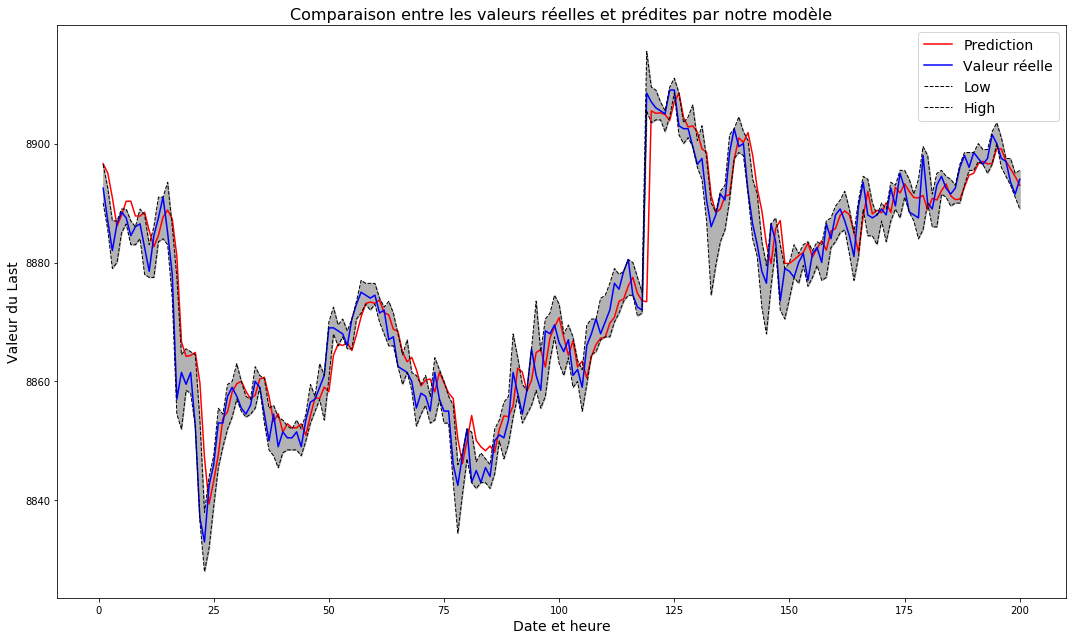

In [27]:
tracer_prediction_no_date(200,prediction,reel,low,high)

In [28]:
#Calcul de la RMSE
rmse = sqrt(mean_squared_error(prediction, reel))
rmse = rmse/len(reel)
rmse

0.007424912789491504

In [29]:
def classification (inv_yhat, dataframe, time_lag):
    df_2013_testing_set = dataframe.iloc[limit+time_lag:,:]
    Last_hat=[]
    Last_hat = inv_yhat
    df_2013_testing_set.insert(9,'Last_hat',Last_hat)
    Y_hat=[]
    n_test = df_2013_testing_set.shape[0]
    for i in range (1,n_test) : 
        if df_2013_testing_set.iloc[i,9]<df_2013_testing_set.iloc[i-1,9]:
            Y_hat.append(-1)
        if df_2013_testing_set.iloc[i,9]==df_2013_testing_set.iloc[i-1,9]:
            Y_hat.append(0)
        if df_2013_testing_set.iloc[i,9]>df_2013_testing_set.iloc[i-1,9]:
            Y_hat.append(1) 
    l = len(Y_hat)
    print("La longueur de la liste des labels prédit est : %s" %l)
    print("La longueur du dataframe est : %s" %n_test)
    df_2013_testing_set = df_2013_testing_set.iloc[1:,:]
    n_test=df_2013_testing_set.shape[0]
    print()
    print("La longueur de la liste des labels est : %s" %l)
    print("La longueur du dataframe privé de sa première ligne est : %s" %n_test)
    df_2013_testing_set.insert(10,'Y_hat',Y_hat)
    return (df_2013_testing_set)

In [30]:
df_prediction = classification(prediction, df_2013, 2)
df_prediction

La longueur de la liste des labels prédit est : 6046
La longueur du dataframe est : 6047

La longueur de la liste des labels est : 6046
La longueur du dataframe privé de sa première ligne est : 6046


,date_time,Time,Open,High,Low,Last,Close,close_zscore,Y,Last_hat,Y_hat
24197,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-41124,-1.686333,-1,8895.053567,-1
24198,2013-10-17 08:25:00,1900-01-01 08:25:00,8887.0,8887.0,8879.0,8882.0,-41288,-2.944547,-1,8890.903336,-1
24199,2013-10-17 08:30:00,1900-01-01 08:30:00,8881.5,8887.0,8880.0,8886.5,-41228,-2.035422,1,8886.137322,-1
24200,2013-10-17 08:35:00,1900-01-01 08:35:00,8886.5,8889.0,8885.0,8888.5,-41207,-1.643969,1,8887.948216,1
24201,2013-10-17 08:40:00,1900-01-01 08:40:00,8888.0,8889.0,8886.5,8887.5,-41212,-1.520592,-1,8890.302819,1
...,...,...,...,...,...,...,...,...,...,...,...
30238,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,9652.5,-39561,1.760153,1,9511.838151,-1
30239,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,9655.5,-39531,1.858150,1,9513.090402,1
30240,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,9658.0,-39538,1.592525,1,9515.269747,1
30241,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,9658.0,-39519,1.600485,0,9516.705682,1


In [31]:
def calcul_erreur_classification (df_err):
    s = 0
    n = df_err.shape[0]
    for i in range (0,n):
        if df_err.iloc[i,8] != df_err.iloc[i,10]:
            s+=1
    erreur = s/n
    return(erreur)

In [32]:
erreur = calcul_erreur_classification(df_prediction)
erreur

0.5704598081376117